<a href="https://colab.research.google.com/github/z-xylym/LSTM-learning/blob/main/lstm_rumor_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()


Saving rumors_v170613.json to rumors_v170613.json


In [9]:
filename = list(uploaded.keys())[0]


In [7]:
import json
from google.colab import files



In [10]:
data = []
with open(filename, "r", encoding="utf-8") as f:
    for line in f:
        try:
            data.append(json.loads(line.strip()))  # 解析 JSON
        except json.JSONDecodeError as e:
            print(f"JSON 解析错误: {e}")

# 4. 输出数据的前5条，检查是否正确
print(f"总共有 {len(data)} 条谣言数据")
print(json.dumps(data[:5], indent=2, ensure_ascii=False))  # 美化输出前5条数据

总共有 31669 条谣言数据
[
  {
    "rumorCode": "K1CaN8wJj76ol",
    "title": "@隆闯天涯 举报@浅雪深洋 不实信息",
    "informerName": "隆闯天涯",
    "informerUrl": "http://weibo.com/u/1842734325",
    "rumormongerName": "浅雪深洋",
    "rumormongerUrl": "http://weibo.com/u/2592892063",
    "rumorText": "急找孩子，求转 实验小学寻人启事13930886687帮忙扩散，今天上午一个三岁多小女孩在锦绣花园小区附近被人拐走了，小女孩能说出她爸爸的手机号码 从监控上看是被一个四十多岁男人抱走了现大人都急疯了 有知情者请告之 万分感谢 看到信息的兄弟姐妹留意一下 联系人 张静杰13930886687如果看一眼懒得 ",
    "visitTimes": 3,
    "result": "经查，该微博称“有孩子被抢”不实，类似消息近两年在网上广为流传且都已经被当地警方辟谣，详情：http://weibo.com/2656274875/CodNboTCH，被举报人构成“发布不实信息”，虽无即时危险，但应予澄清，现根据《微博社区管理规定》 （http://service.account.weibo.com/roles/guiding）第19条，予以标识处理。",
    "publishTime": "2016-06-15 09:02"
  },
  {
    "rumorCode": "K1CaN8wJj76ok",
    "title": "@隆闯天涯 举报@cat精品微店 不实信息",
    "informerName": "隆闯天涯",
    "informerUrl": "http://weibo.com/u/1842734325",
    "rumormongerName": "cat精品微店",
    "rumormongerUrl": "http://weibo.com/u/5722939786",
    "rumorText": "急帮忙转寻人启示13759695559帮忙扩散，今天上午一个三岁多小女孩在世

In [12]:
pip install pkuseg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 MB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pkuseg: filename=pkuseg-0.0.25-cp311-cp311-linux_x86_64.whl size=50751331 sha256=86f7121f9728843e87222bc7d04010ddc2bdf540c44e23bbcea82c8d0843d9fa
  Stored in directory: /root/.cache/pip/wheels/6e/b9/d9/3cfceef165811a9dfc46c94ab798e429cf413de917aba799ca
Successfully built pkuseg


In [14]:
pip install config

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import  torch
import jieba
import bz2
import  os,re
import gensim
import pkuseg
import numpy as np
from gensim.models import KeyedVectors   #gensim用来加载预训练词向量
import config as config



In [16]:
from google.colab import files
uploaded = files.upload()

Saving ced_dataset.txt to ced_dataset.txt


In [28]:
#解压预训练好的词向量bz2文件
def bz2Decompress():
    if os.path.exists ("/content/sgns.weibo.bigram.bz2") == False:
        with open ("/content/sgns.weibo.bigram.bz2", 'wb') as new_file, open ("/content/sgns.weibo.bigram.bz2", 'rb') as file:
            decompressor = bz2.BZ2Decompressor ()
            for data in iter (lambda: file.read (100 * 1024), b''):
                new_file.write (decompressor.decompress (data))

In [44]:
import bz2
import os

def bz2Decompress():
    compressed_file_path = "/content/sgns.weibo.bigram.bz2"
    output_file_path = "/content/sgns.weibo.bigram"  # 指定解压后的文件路径

    # 检查压缩文件是否存在
    if not os.path.exists(compressed_file_path):
        print(f"Error: The file {compressed_file_path} does not exist.")
        return

    # 解压过程
    with open(output_file_path, 'wb') as new_file:
        with open(compressed_file_path, 'rb') as file:
            decompressor = bz2.BZ2Decompressor()
            for data in iter(lambda: file.read(100 * 1024), b''):
                new_file.write(decompressor.decompress(data))

    # 检查解压后的文件是否存在
    if os.path.exists(output_file_path):
        print(f"File successfully decompressed to: {output_file_path}")
    else:
        print("Error: Decompression failed or file not found.")

# 调用解压函数
bz2Decompress()



File successfully decompressed to: /content/sgns.weibo.bigram


In [45]:
if os.path.exists("/content/sgns.weibo.bigram"):
    print("Decompression successful!")
else:
    print("Decompression failed!")


Decompression successful!


In [61]:
from google.colab import files
uploaded = files.upload()

Saving stopwords.txt to stopwords.txt


In [46]:
#加载ced_dataset数据，转化成labes,contents
def get_df():
    weibo = pd.read_csv ('/content/ced_dataset.txt', sep='\t', names=['label', 'content'], encoding='utf-8')
    weibo = weibo.dropna ()  # 删除缺失值
    return  weibo['label'].values.tolist(),weibo['content'].values.tolist()

In [47]:
#jieba分词
def jieba_cut(contents):
    contents_S=[]
    for line in contents:
        current_segment=jieba.lcut(line)#列表，元素为分割出来的词
        contents_S.append (current_segment)
    return contents_S


In [48]:
#pkuseg分词，可以选择微博领域
def pkuseg_cut(contents,model_name="web"):
    seg = pkuseg.pkuseg (model_name='web')  # 程序会自动下载所对应的细领域模型
    contents_S = []
    for line in contents:
        line = re.sub ("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", line)
        current_segment = jieba.lcut (line)  # 列表，元素为分割出来的词
        contents_S.append(current_segment)
    return contents_S

In [63]:
#获取停用词集合
def get_stopwords():
    stopwords = pd.read_csv ("/content/stopwords.txt", index_col=False, sep="\t", quoting=3, names=['stopword'],
                             encoding='utf-8')
    return  set(stopwords['stopword'].values.tolist())

In [50]:
#去除停用词
def drop_stopwords(contents,stopwords):
    contents_clean = []
    all_words = []
    for line in contents:
        line_clean = []
        for word in line:
            if word in stopwords:
                continue
            line_clean.append(word)
            all_words.append(str(word))    #str()转换为字符串##记录所有line_clean中的词
        contents_clean.append(line_clean)
    return contents_clean,all_words

In [57]:
def get_word2vec():
    if os.path.exists("/content/sgns.weibo.bigram") == False:
        bz2Decompress()
    word2vec=KeyedVectors.load_word2vec_format('/content/sgns.weibo.bigram',binary=False,unicode_errors="ignore")
    return word2vec

In [52]:
## 返回预处理后的（labels，index)=>([1},[234 1234])
def key_to_index(contents,word2vec,num_words):
    '''
    :param contents:
    :param word2vec:预训练好的词向量模型，词向量根据使用频率降序排列
    :param num_words: 最大词汇数，选择使用前new_words个使用评率最高的词
    :return:
    '''
    train_tokens=[]
    contents_S = pkuseg_cut(contents)
    stopword = get_stopwords ()
    contents_clean, all_words = drop_stopwords (contents_S, stopword)
    for line_clean in contents_clean:
        for i, key in enumerate(line_clean):
            try:
                index=word2vec.key_to_index[key]
                if index<num_words:
                    line_clean[i]=word2vec.key_to_index[key]
                else:
                    line_clean[i] =0  #超出前num_words个词用0代替
            except KeyError:  #如果词不在字典中，则输出0
                line_clean[i]=0
        train_tokens.append(line_clean)
    return train_tokens


In [53]:
# 返回预处理后的（labels，contents)=>([1},[求 转发])
def labels_contents():
    labels, contents = get_df()
    contents_S = jieba_cut (contents)
    stopword = get_stopwords ()
    contents_clean, all_words = drop_stopwords (contents_S, stopword)
    contents_clean=[" ".join (x) for x in contents_clean]
    return labels, contents_clean

In [54]:
def get_maxlength(train_tokens):
    num_tokens = [len (tokens) for tokens in train_tokens]
    num_tokens = np.array (num_tokens)
    # 取tokens平均值并加上两个tokens的标准差，
    # 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
    max_tokens = np.mean (num_tokens) + 2 * np.std (num_tokens)
    max_tokens = int (max_tokens)
    return max_tokens


In [55]:
def padding_truncating(train_tokens,maxlen):
    for i,token in enumerate(train_tokens):
        if len(token)>maxlen:
            train_tokens[i]=token[len(token)-maxlen:]
        elif len(token)<maxlen:
            train_tokens[i]=[0]*(maxlen-len(token))+token
    return train_tokens

In [64]:
import torch




num_words =50000  #最大词汇数，选择使用前new_words个使用评率最高的词
maxlength =58     #文本最大长度,utils包中的get_maxlength() 方法获得通过 ,取tokens平均值并加上两个tokens的标准差，
                                     # 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本

embedding_dim = 300 #词向量维度
lstm_hidden_size=128  #LSTM 隐含层size
lstm_num_layers=2     #LSTM 层数
lstm_bidirectional=True #LSTM是否为双向
lr=1e-3    #学习率

dropout = 0.2  #随机置零的概率
batch_size = 64
early_stop_cnt=6   #验证集准确率不提升时最多等待epoch，早停
epoch=30           #迭代次数


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [77]:
from google.colab import files
uploaded = files.upload()


Saving config.py to config.py


In [80]:
!ls -l /content


total 753736
-rw-r--r-- 1 root root   1026143 Feb 10 13:58 ced_dataset.txt
-rw-r--r-- 1 root root       808 Feb 10 15:41 config.py
drwx------ 6 root root      4096 Feb 10 12:11 drive
-rw-r--r-- 1 root root  34155221 Feb 10 12:14 rumors_v170613.json
drwxr-xr-x 1 root root      4096 Feb  6 14:19 sample_data
-rw-r--r-- 1 root root 557111141 Feb 10 14:36 sgns.weibo.bigram
-rw-r--r-- 1 root root 179490373 Feb 10 14:07 sgns.weibo.bigram.bz2
-rw-r--r-- 1 root root     17672 Feb 10 15:29 stopwords.txt


In [82]:
sys.path.insert(0, "/content")
import config
print(config.num_words)  # 确保它能正确打印数值


50000


In [81]:
import sys
if "config" in sys.modules:
    del sys.modules["config"]


In [83]:
exec(open("/content/config.py").read())
print(num_words)


50000


In [85]:
def get_embedding(word2vec,num_words=50000,embedding_dim=300):
    '''
    :param num_words: 只选择使用前50k个使用频率最高的词
    :param embedding_dim: 词向量维度
    :param word2vec: 预训练好的词向量模型
    :return:
    '''
    embedding_matrix = np.zeros ((num_words, embedding_dim))
    # embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
    # 维度为 50000 * 300
    for i in range (num_words):
        # embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]#前50000个index对应的词的词向量
        embedding_matrix[i, :] = word2vec[i]  # 前50000个index对应的词的词向量
    embedding_matrix = embedding_matrix.astype ('float32')
    return torch.from_numpy(embedding_matrix)

word2vec=get_word2vec()

embedding=get_embedding(word2vec,num_words=config.num_words,embedding_dim=config.embedding_dim)

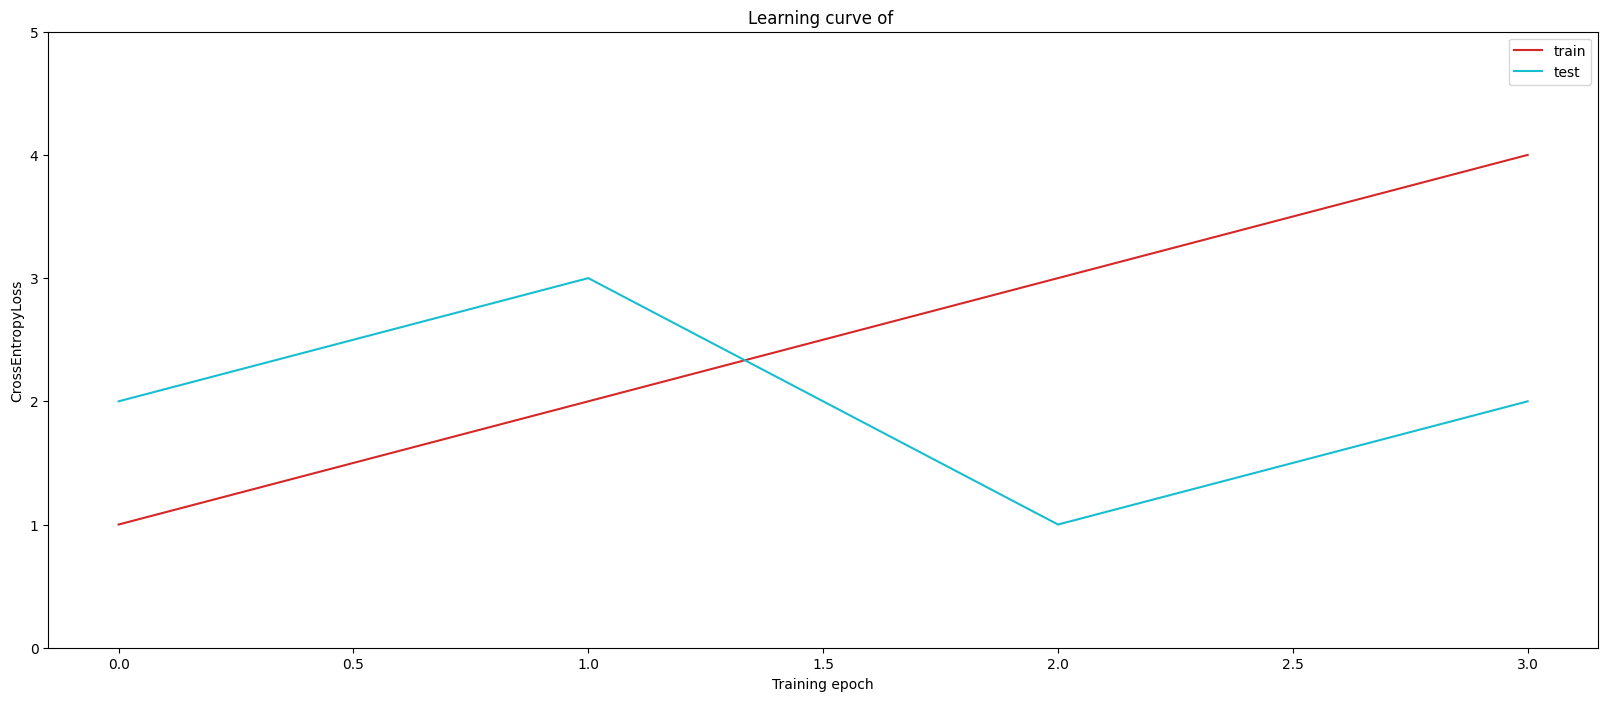

In [86]:
def plot_learning_curve(train_loss,test_loss, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''

    plt.figure(figsize=(20, 8))
    plt.plot(train_loss, c='tab:red', label='train')
    plt.plot(test_loss, c='tab:cyan', label='test')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training epoch')
    plt.ylabel('CrossEntropyLoss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

if __name__ == '__main__':
    plot_learning_curve([1,2,3,4],[2,3,1,2])
    # labels,contents=labels_contents()
    # print(labels[:5])
    # print(contents[:5])